# **Setup**

In [0]:
# !rm -rf Rooftop-Segmentation

In [0]:
# ! unzip Rooftop-Segmentation.zip
# % cd Rooftop-Segmentation

# **Rooftop Segmentation**

In [2]:
import sys
sys.path.insert(0, 'tools/')
from align import DEMOrthoAlign
from segment import segmentDEM
from findFeature import findDEMFeature
from roofCreate import createMask
from findVegetation import removeLABRoof,removeNDVIRoof
from smoothRoof import smooth
from shapeFile import createShapeFile
import numpy as np
from matplotlib import pyplot as plt
import time
from sklearn.externals import joblib
import cv2

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
minBuildingHeight=1
ir=0

In [0]:
#---------------------------------Read data-----------------------------------------------
# demFileName = "dsm_potsdam_02_14.tif"
# orthoFileName = "top_potsdam_2_14_RGB.tif"
# IRFileName = "top_potsdam_2_14_IRRG.tif"
# locationDEM = "/Users/kritiksoman/Documents/Aerial/untitled folder/potsdam/DSM/"
# locationOrtho = "/Users/kritiksoman/Documents/Aerial/untitled folder/potsdam/2_Ortho_RGB/"
# locationIR = "/Users/kritiksoman/Documents/Aerial/untitled folder/potsdam/3_Ortho_IRRG/"

folder = "data1/"
demFileName = "demClipped.tif"
orthoFileName = "orthoAligned.tif"
IRFileName = "IR.tif"
#locationDEM = "/Users/kritiksoman/Documents/Aerial/untitled folder/" + folder
locationDEM=folder
locationOrtho = locationDEM

startTime=time.time()
original_dem,original_ortho,coordRef=DEMOrthoAlign(locationDEM,locationOrtho,demFileName,orthoFileName)
height,width=original_dem.shape
#--------------------------------/Read data-----------------------------------------------


In [0]:
#--------------------------------Segment DEM----------------------------------------------
index,n = segmentDEM(original_dem)
print('1. Segmentation in ',time.time()-startTime)
#-------------------------------/Segment DEM----------------------------------------------

#-------------------------------Detect Ground---------------------------------------------
f,region = findDEMFeature(original_dem,index)
clf = joblib.load('groundTreeModel.pkl')
p_labs = clf.predict(f[:,1:6])
# print('Label,n_holes,avgHole,n_defect,tn_defects,smallerThan')
print(f)
print(p_labs)

gList=[]
gListStd=[]
ground = np.zeros(original_dem.shape)
posGround=np.where(p_labs==1)[0]
for i in range(0,len(posGround)):
	ground = ground + (index==f[posGround[i]][0])
	gList.append(f[posGround[i]][0])
	gListStd.append(f[posGround[i]][-1])
#------------------------------/Detect Ground---------------------------------------------


In [10]:
#------------------------------Create Roof Mask-------------------------------------------
roofMask = createMask(original_dem,index,ground,region,gList,gListStd,minBuildingHeight)
print('2. Roofmask in ',time.time()-startTime)

# Remove Vegetation
if ir == 0:
	roofMask2,vegeMask,vegetation=removeLABRoof(roofMask,original_ortho,index,region)
else:
	roofMask2,vegeMask,vegetation=removeNDVIRoof(locationIR,IRFileName,roofMask,original_ortho,index,region)


roofMask2=roofMask2>0
roofnew = smooth(roofMask2.astype(np.uint8))
#-----------------------------/Create Roof Mask-------------------------------------------

#------------------------------Clutter Mask-----------------------------------------------
clutter = np.zeros(original_dem.shape)
for i in range(0,len(region)):
	if region[i].area<5000:
		xy=region[i].coords
		clutter[xy[:,0],xy[:,1]]=255
clutter = np.multiply(clutter>0,roofnew>0)*255
#-----------------------------/Clutter Mask-----------------------------------------------


2. Roofmask in  91.1921398639679


In [11]:
#------------------------------Clutter Mask-----------------------------------------------
clutter = np.zeros(original_dem.shape)
for i in range(0,len(region)):
	if region[i].area<5000:
		xy=region[i].coords
		clutter[xy[:,0],xy[:,1]]=255
clutter = np.multiply(clutter>0,roofnew>0)*255
#-----------------------------/Clutter Mask-----------------------------------------------

#------------------------------Export Result-----------------------------------------------
createShapeFile(roofnew,demFileName,coordRef,1)
createShapeFile(clutter,demFileName + "_clutter",coordRef,0)
saveImg=np.zeros((height,width,3),dtype=np.uint8)
saveImg=saveImg+np.dstack((roofnew,np.zeros((height,width,2),dtype=np.uint8)))
saveImg[np.where((saveImg[:,:,0]==0) & (saveImg[:,:,1]==0) & (saveImg[:,:,2]==0))]=255
cv2.imwrite(demFileName+'_roof.png',saveImg)
print('3. Completed in ',time.time()-startTime)
#-----------------------------/Export Result-----------------------------------------------


3. Completed in  94.92459511756897


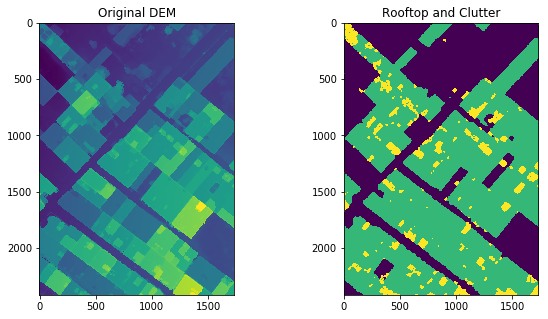

In [18]:
#plot results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5));
ax[0].imshow(original_dem);
ax[0].set_title('Original DEM');
ax[1].imshow(roofnew+clutter*0.5);
ax[1].set_title('Rooftop and Clutter');